<a href="https://colab.research.google.com/github/platypusjerry/BTP--Data-Driven-Design/blob/main/BTP_DDCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install fsspec

     |████████████████████████████████| 119 kB 5.0 MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg     
%matplotlib inline  
import urllib.request
from urllib.request import urlopen
import requests
from google.colab import files
import io

In [3]:
from scipy import optimize
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial import distance as sci

In [ ]:
'''
from google.colab import files
uploaded = files.upload()
'''

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df_main = pd.read_excel('/content/drive/MyDrive/DATA/NEW_DAT/irreg_holes/features_train.xlsx')
df_test = pd.read_excel('/content/drive/MyDrive/DATA/NEW_DAT/quadrant/features_test.xlsx')

In [ ]:
df_main.head(5)

,Node Number,X Location (m),Y Location (m),Z Location (m),Directional Deformation (m),Total Deformation (m),Equivalent Elastic Strain (m/m),Maximum Principal Elastic Strain (m/m),Strain Energy (J),Maximum Principal Stress (Pa),Equivalent (von-Mises) Stress (Pa)
0,1,0.116440,0.005,0.11275,7.053900e-09,2.253000e-08,6.165800e-07,6.310100e-07,5.896100e-09,143260.0,134270.0
1,2,0.116440,0.010,0.11275,7.102900e-09,2.247700e-08,6.176700e-07,6.358100e-07,3.853300e-09,145200.0,134510.0
2,3,0.116440,0.015,0.11275,7.102900e-09,2.247700e-08,6.176700e-07,6.358100e-07,6.795600e-09,145200.0,134510.0
3,4,0.116440,0.020,0.11275,7.053900e-09,2.253000e-08,6.165800e-07,6.310100e-07,6.613400e-09,143260.0,134270.0
4,5,0.067054,0.005,0.10712,6.750600e-09,1.769700e-08,3.374600e-07,3.461400e-07,4.461600e-09,81362.0,73496.0


In [ ]:
df_test.head(5)

,Node Number,X Location (m),Y Location (m),Z Location (m),Directional Deformation (m),Total Deformation (m),Equivalent Elastic Strain (m/m),Maximum Principal Elastic Strain (m/m),Strain Energy (J),Equivalent (von-Mises) Stress (Pa),Maximum Principal Stress (Pa)
0,1,0.052503,0.004398,0.089139,-0.000023,0.000334,0.005679,0.002419,0.086290,1235200000,186000000.0
1,2,0.052503,0.008797,0.089139,-0.000023,0.000333,0.005650,0.002390,0.080515,1228700000,180090000.0
2,3,0.052503,0.013195,0.089139,-0.000023,0.000334,0.005679,0.002419,0.080515,1235200000,186000000.0
3,4,0.069750,0.004398,0.115080,0.000005,0.000522,0.003442,0.002011,0.086290,748240000,262600000.0
4,5,0.069750,0.008797,0.115080,0.000006,0.000522,0.003407,0.002017,0.177490,740840000,270530000.0


Text(0.5, 0, 'Directionnal Deformation (m)')

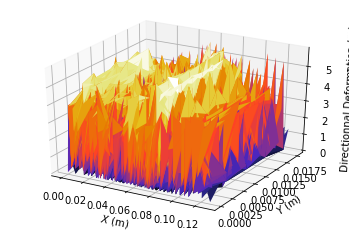

In [5]:
X = df_test['X Location (m)']
Y = df_test['Y Location (m)']
Z = df_main['Total Deformation (m)']

ax = plt.axes(projection='3d')
ax.plot_trisurf(X, Y, Z, cmap=plt.cm.CMRmap)

ax.set_xlabel('$X$ (m)')
ax.set_ylabel('$Y$ (m)')
ax.set_zlabel('Directionnal Deformation (m)')


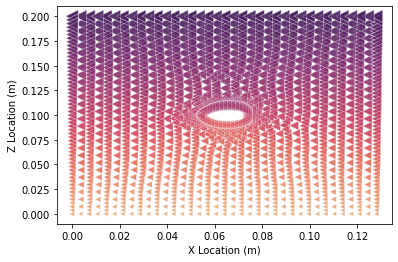

In [6]:
sns.scatterplot(x="X Location (m)", y="Z Location (m)", data=df_test, hue='Total Deformation (m)', size="Total Deformation (m)", sizes=(20, 150),
                palette=sns.color_palette("flare", as_cmap=True), alpha=0.4, legend=False, marker="<")

# **TRAINING**

In [7]:
df_train = df_main[['X Location (m)', 'Y Location (m)', 'Z Location (m)', 'Total Deformation (m)', 'Maximum Principal Elastic Strain (m/m)']]
X = df_train.to_numpy()
print(X)

[[1.1644e-01 5.0000e-03 1.1275e-01 2.2530e-08 6.3101e-07]
 [1.1644e-01 1.0000e-02 1.1275e-01 2.2477e-08 6.3581e-07]
 [1.1644e-01 1.5000e-02 1.1275e-01 2.2477e-08 6.3581e-07]
 ...
 [2.6642e-02 0.0000e+00 6.6934e-02 6.4365e-09 3.3192e-08]
 [2.3477e-02 0.0000e+00 6.5107e-02 5.1276e-09 5.2568e-08]
 [2.0893e-02 0.0000e+00 6.2523e-02 4.3280e-09 4.7075e-08]]


In [8]:
df_y = df_main['Maximum Principal Stress (Pa)']
y = df_y.to_numpy()
print(y)

[143260.   145200.   145200.   ...    941.62    315.45    244.98]


In [9]:
X_train, X_CV, y_train, y_CV = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape, y_train.shape, X_CV.shape, y_CV.shape)

(9004, 5) (9004,) (4436, 5) (4436,)


In [10]:
sgd = SGDRegressor(max_iter=1000, tol=1e-3, early_stopping=True, validation_fraction=0.4)
reg = make_pipeline(StandardScaler(), sgd)
reg.fit(X, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0001, average=False, early_stopping=True,
                              epsilon=0.1, eta0=0.01, fit_intercept=True,
                              l1_ratio=0.15, learning_rate='invscaling',
                              loss='squared_loss', max_iter=1000,
                              n_iter_no_change=5, penalty='l2', power_t=0.25,
                              random_state=None, shuffle=True, tol=0.001,
                              validation_fraction=0.4, verbose=0,
                              warm_start=False))],
         verbose=False)

In [11]:
pred_1 = reg.predict(X_CV)
print(pred_1, y_CV)

[62417.12400238 12800.15315973 61740.02441053 ... 62169.12068532
 72934.63889524 23130.98091003] [65749. 10343. 62829. ... 62082. 71861. 26472.]


In [12]:
preddf = pd.DataFrame(data=pred_1, columns=['Cross-validated stress field sample (Pa)'])
Xdf = pd.DataFrame(data=X_CV, columns=['X Location (m)', 'Y Location (m)', 'Z Location (m)', 'Total Deformation (m)', 'Maximum Principal Elastic Strain (m/m)'])

cvpred_df = pd.concat([preddf, Xdf], axis=1)
cvpred_df

,Cross-validated stress field sample (Pa),X Location (m),Y Location (m),Z Location (m),Total Deformation (m),Maximum Principal Elastic Strain (m/m)
0,62417.124002,0.049534,0.0000,0.080174,1.809500e-08,2.853100e-07
1,12800.153160,0.028640,0.0025,0.188220,4.905700e-10,4.512400e-08
2,61740.024411,0.088846,0.0150,0.014950,4.636800e-08,2.628400e-07
3,61904.095481,0.095750,0.0100,0.022289,4.593600e-08,2.614900e-07
4,66107.553446,0.071386,0.0100,0.043418,3.373300e-08,2.916500e-07
...,...,...,...,...,...,...
4431,62853.162285,0.078222,0.0175,0.022500,4.149600e-08,2.726500e-07
4432,55335.646392,0.120500,0.0000,0.155560,1.000300e-08,2.375600e-07
4433,62169.120685,0.109680,0.0050,0.029695,4.713700e-08,2.580400e-07
4434,72934.638895,0.117390,0.0100,0.080619,3.643500e-08,3.043900e-07


Training MSE: 31263544.9293

Training r2: 0.9576 



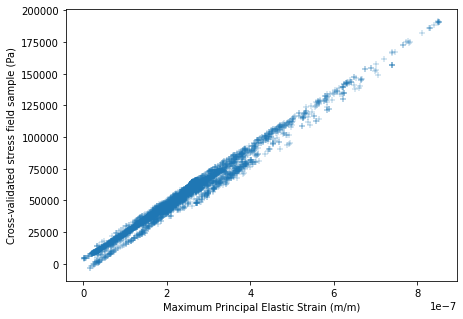

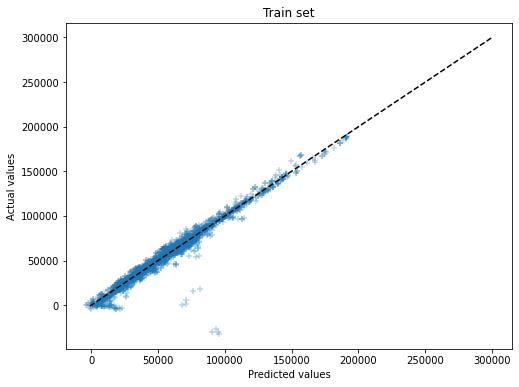

In [13]:
print("Training MSE:", round(mean_squared_error(y_CV, pred_1),4))
print("\nTraining r2:", round(r2_score(y_CV, pred_1),4), "\n")

fig = plt.gcf()

fig.set_size_inches(7,5)
sns.scatterplot(data=cvpred_df, x="Maximum Principal Elastic Strain (m/m)", y="Cross-validated stress field sample (Pa)", alpha=0.7, marker='+')


fig, ax= plt.subplots(1, figsize=(8,6))
ax.scatter(cvpred_df['Cross-validated stress field sample (Pa)'], y_CV, alpha=0.3, marker='+')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Train set')
ax.plot(list(range(-1000, 300000)), list(range(-1000,300000)), color='black', linestyle='--') 

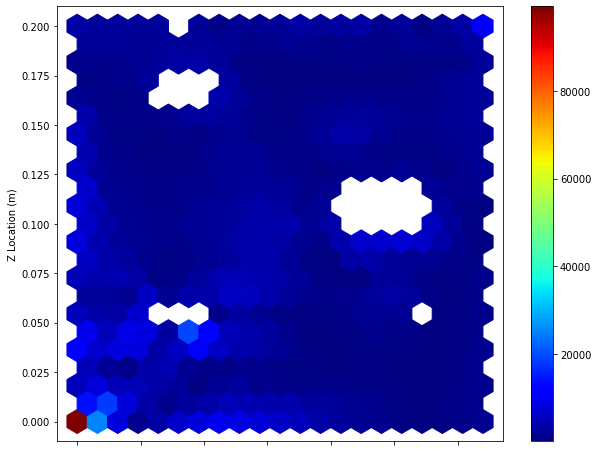

In [14]:
#@title
from sklearn.metrics.pairwise import paired_distances
X1 = y_CV.reshape(-1,1)
Y1 = pred_1.reshape(-1,1)
z = paired_distances(X1, Y1)
df_error2 = pd.DataFrame(data=z, columns=['error_dist'])

newpd = pd.concat([df_error2, cvpred_df], axis=1)

plot = newpd.plot.hexbin(x="X Location (m)", y="Z Location (m)", C="error_dist", 
                             xlabel="X location (m)", cmap='jet', gridsize=20, figsize=(10,8), legend=True)



# **TEST**

In [15]:
df_temp_test = df_test[['X Location (m)', 'Y Location (m)', 'Z Location (m)', 'Total Deformation (m)', 'Equivalent Elastic Strain (m/m)']]
X_test = df_temp_test.to_numpy()

y_test = df_test['Maximum Principal Stress (Pa)']
y_test = y_test.to_numpy()

In [16]:
pred = reg.predict(X_test)
pred

array([1.36681195e+09, 1.36012449e+09, 1.36681194e+09, ...,
       8.82624719e+08, 9.18712694e+08, 9.59460014e+08])

In [17]:
print("Testing MSE:", round(mean_squared_error(y_test, pred),4))
print("Testing r2:", round(r2_score(y_test, pred),4))

Testing MSE: 1.1439894152784728e+18
Testing r2: -80.9542


In [18]:
xd = pd.DataFrame(data=pred, columns=['Predicted stress field (Pa)'])
cd = pd.DataFrame(data= y_test, columns=['Actual Maximum Principal Stress (Pa)'] )
#pd.to_csv("pred_result.csv")
'''
https://drive.google.com/file/d/1q9OaAMFo8YKhOEHgl76lBFaTih3j3uXl/view?usp=sharing
'''

'\nhttps://drive.google.com/file/d/1q9OaAMFo8YKhOEHgl76lBFaTih3j3uXl/view?usp=sharing\n'

In [20]:
plt_temp = df_test[['X Location (m)', 'Y Location (m)', 'Z Location (m)', 'Total Deformation (m)', 'Maximum Principal Elastic Strain (m/m)' ]]
df_plot = pd.concat([xd, cd, plt_temp], axis=1)
df_plot

,Predicted stress field (Pa),Actual Maximum Principal Stress (Pa),X Location (m),Y Location (m),Z Location (m),Total Deformation (m),Maximum Principal Elastic Strain (m/m)
0,1.366812e+09,186000000.0,0.052503,0.004398,0.089139,0.000334,0.002419
1,1.360124e+09,180090000.0,0.052503,0.008797,0.089139,0.000333,0.002390
2,1.366812e+09,186000000.0,0.052503,0.013195,0.089139,0.000334,0.002419
3,9.420746e+08,262600000.0,0.069750,0.004398,0.115080,0.000522,0.002011
4,9.345368e+08,270530000.0,0.069750,0.008797,0.115080,0.000522,0.002017
...,...,...,...,...,...,...,...
11332,8.466686e+08,-222860000.0,0.039111,0.000000,0.000000,0.000000,0.001105
11333,8.616357e+08,-224350000.0,0.032000,0.000000,0.000000,0.000000,0.001127
11334,8.826247e+08,-226150000.0,0.024889,0.000000,0.000000,0.000000,0.001160
11335,9.187127e+08,-228710000.0,0.017778,0.000000,0.000000,0.000000,0.001222


In [ ]:
#sns.scatterplot(x="X Location (m)", y="Z Location (m)", data=df_plot, hue='Predicted stress field', size="Predicted stress field", sizes=(20, 150),
#               palette=sns.color_palette("flare", as_cmap=True), alpha=0.4, legend=False, marker="<")

Text(0.5, 1.0, 'Test set')

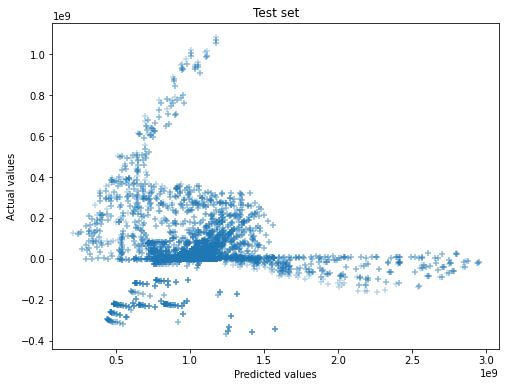

In [21]:
fig, ax= plt.subplots(1, figsize=(8,6))
ax.scatter(df_plot['Predicted stress field (Pa)'], df_plot['Actual Maximum Principal Stress (Pa)'], alpha=0.3, marker='+')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
ax.set_title('Test set')

In [22]:
from sklearn.metrics.pairwise import paired_distances
actual_stress = df_plot['Actual Maximum Principal Stress (Pa)'].to_numpy()
X = actual_stress.reshape(-1,1)
Y = pred.reshape(-1,1)
z = paired_distances(X, Y)
df_error = pd.DataFrame(data=z, columns=['error_dist'])
df_error



,error_dist
0,1.180812e+09
1,1.180034e+09
2,1.180812e+09
3,6.794746e+08
4,6.640068e+08
...,...
11332,1.069529e+09
11333,1.085986e+09
11334,1.108775e+09
11335,1.147423e+09


In [23]:
df_1 = df_test[['X Location (m)', 'Z Location (m)']]
err_check = pd.concat([df_1, df_error], axis=1)
err_check

,X Location (m),Z Location (m),error_dist
0,0.052503,0.089139,1.180812e+09
1,0.052503,0.089139,1.180034e+09
2,0.052503,0.089139,1.180812e+09
3,0.069750,0.115080,6.794746e+08
4,0.069750,0.115080,6.640068e+08
...,...,...,...
11332,0.039111,0.000000,1.069529e+09
11333,0.032000,0.000000,1.085986e+09
11334,0.024889,0.000000,1.108775e+09
11335,0.017778,0.000000,1.147423e+09


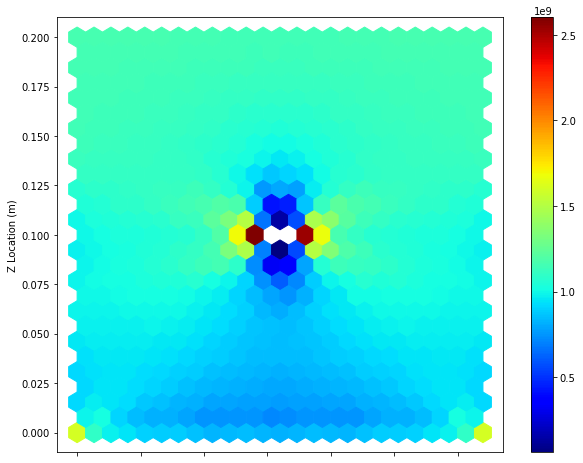

In [24]:
plot = err_check.plot.hexbin(x="X Location (m)", y="Z Location (m)", C="error_dist", 
                             xlabel="X location (m)", cmap='jet', gridsize=24, figsize=(10,8), legend=True)